<a href="https://colab.research.google.com/github/Preeyam1/project1/blob/master/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install feature_engine

In [15]:
!pip install dtale

In [16]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
import dtale
import pickle, joblib
from sqlalchemy import create_engine, text
from urllib.parse import quote

In [19]:
df = pd.read_csv(r"prima_13.csv")


df.info()
# autoeda
dtale.show(df).open_browser()

#Descriptive Analytics
desc = df.describe()

# Datapreprocessing by Pipeline
df.columns
# Seperating input and output variables
df_x = df.drop(['Date', 'Machine_ID', 'Downtime'], axis = 1)
df_y = df[['Downtime']]

# All numeric features
numeric_features = df_x.select_dtypes(exclude = ['object']).columns
numeric_features

# All categorical features
categorical_features = df_x.select_dtypes(include = ['object']).columns
categorical_features# No Categorical features in predictors

# Imputation strategy for numeric columns
num_pipeline = Pipeline([('impute', SimpleImputer(strategy = 'mean')),('scale', MinMaxScaler())])

# Using ColumnTransfer to transform the columns of an array or pandas DataFrame. This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space.
preprocess_pipeline = ColumnTransformer([('numerical', num_pipeline, numeric_features)])

processed = preprocess_pipeline.fit(df_x)  # Pass the raw data through pipeline

processed

# Save the defined pipeline
joblib.dump(processed, 'imp_scale')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           2700 non-null   object 
 1   Machine_ID                     2700 non-null   object 
 2   Load_cells                     2680 non-null   float64
 3   Hydraulic_Pressure(bar)        2694 non-null   float64
 4   Coolant_Pressure(bar)          2700 non-null   float64
 5   Air_System_Pressure(bar)       2700 non-null   float64
 6   Coolant_Temperature(°C)        2700 non-null   float64
 7   Hydraulic_Oil_Temperature(°C)  2700 non-null   float64
 8   Proximity_sensors              2680 non-null   float64
 9   Spindle_Vibration(µm)          2700 non-null   float64
 10  Tool_Vibration(µm)             2700 non-null   float64
 11  Spindle_Speed(RPM)             2694 non-null   float64
 12  Voltage(volts)                 2700 non-null   f

['imp_scale']

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Load_cells                     2700 non-null   float64
 1   Hydraulic_Pressure(bar)        2700 non-null   float64
 2   Coolant_Pressure(bar)          2700 non-null   float64
 3   Air_System_Pressure(bar)       2700 non-null   float64
 4   Coolant_Temperature(°C)        2700 non-null   float64
 5   Hydraulic_Oil_Temperature(°C)  2700 non-null   float64
 6   Proximity_sensors              2700 non-null   float64
 7   Spindle_Vibration(µm)          2700 non-null   float64
 8   Tool_Vibration(µm)             2700 non-null   float64
 9   Spindle_Speed(RPM)             2700 non-null   float64
 10  Voltage(volts)                 2700 non-null   float64
 11  Torque                         2700 non-null   float64
 12  Cutting_Force(kN)              2700 non-null   f

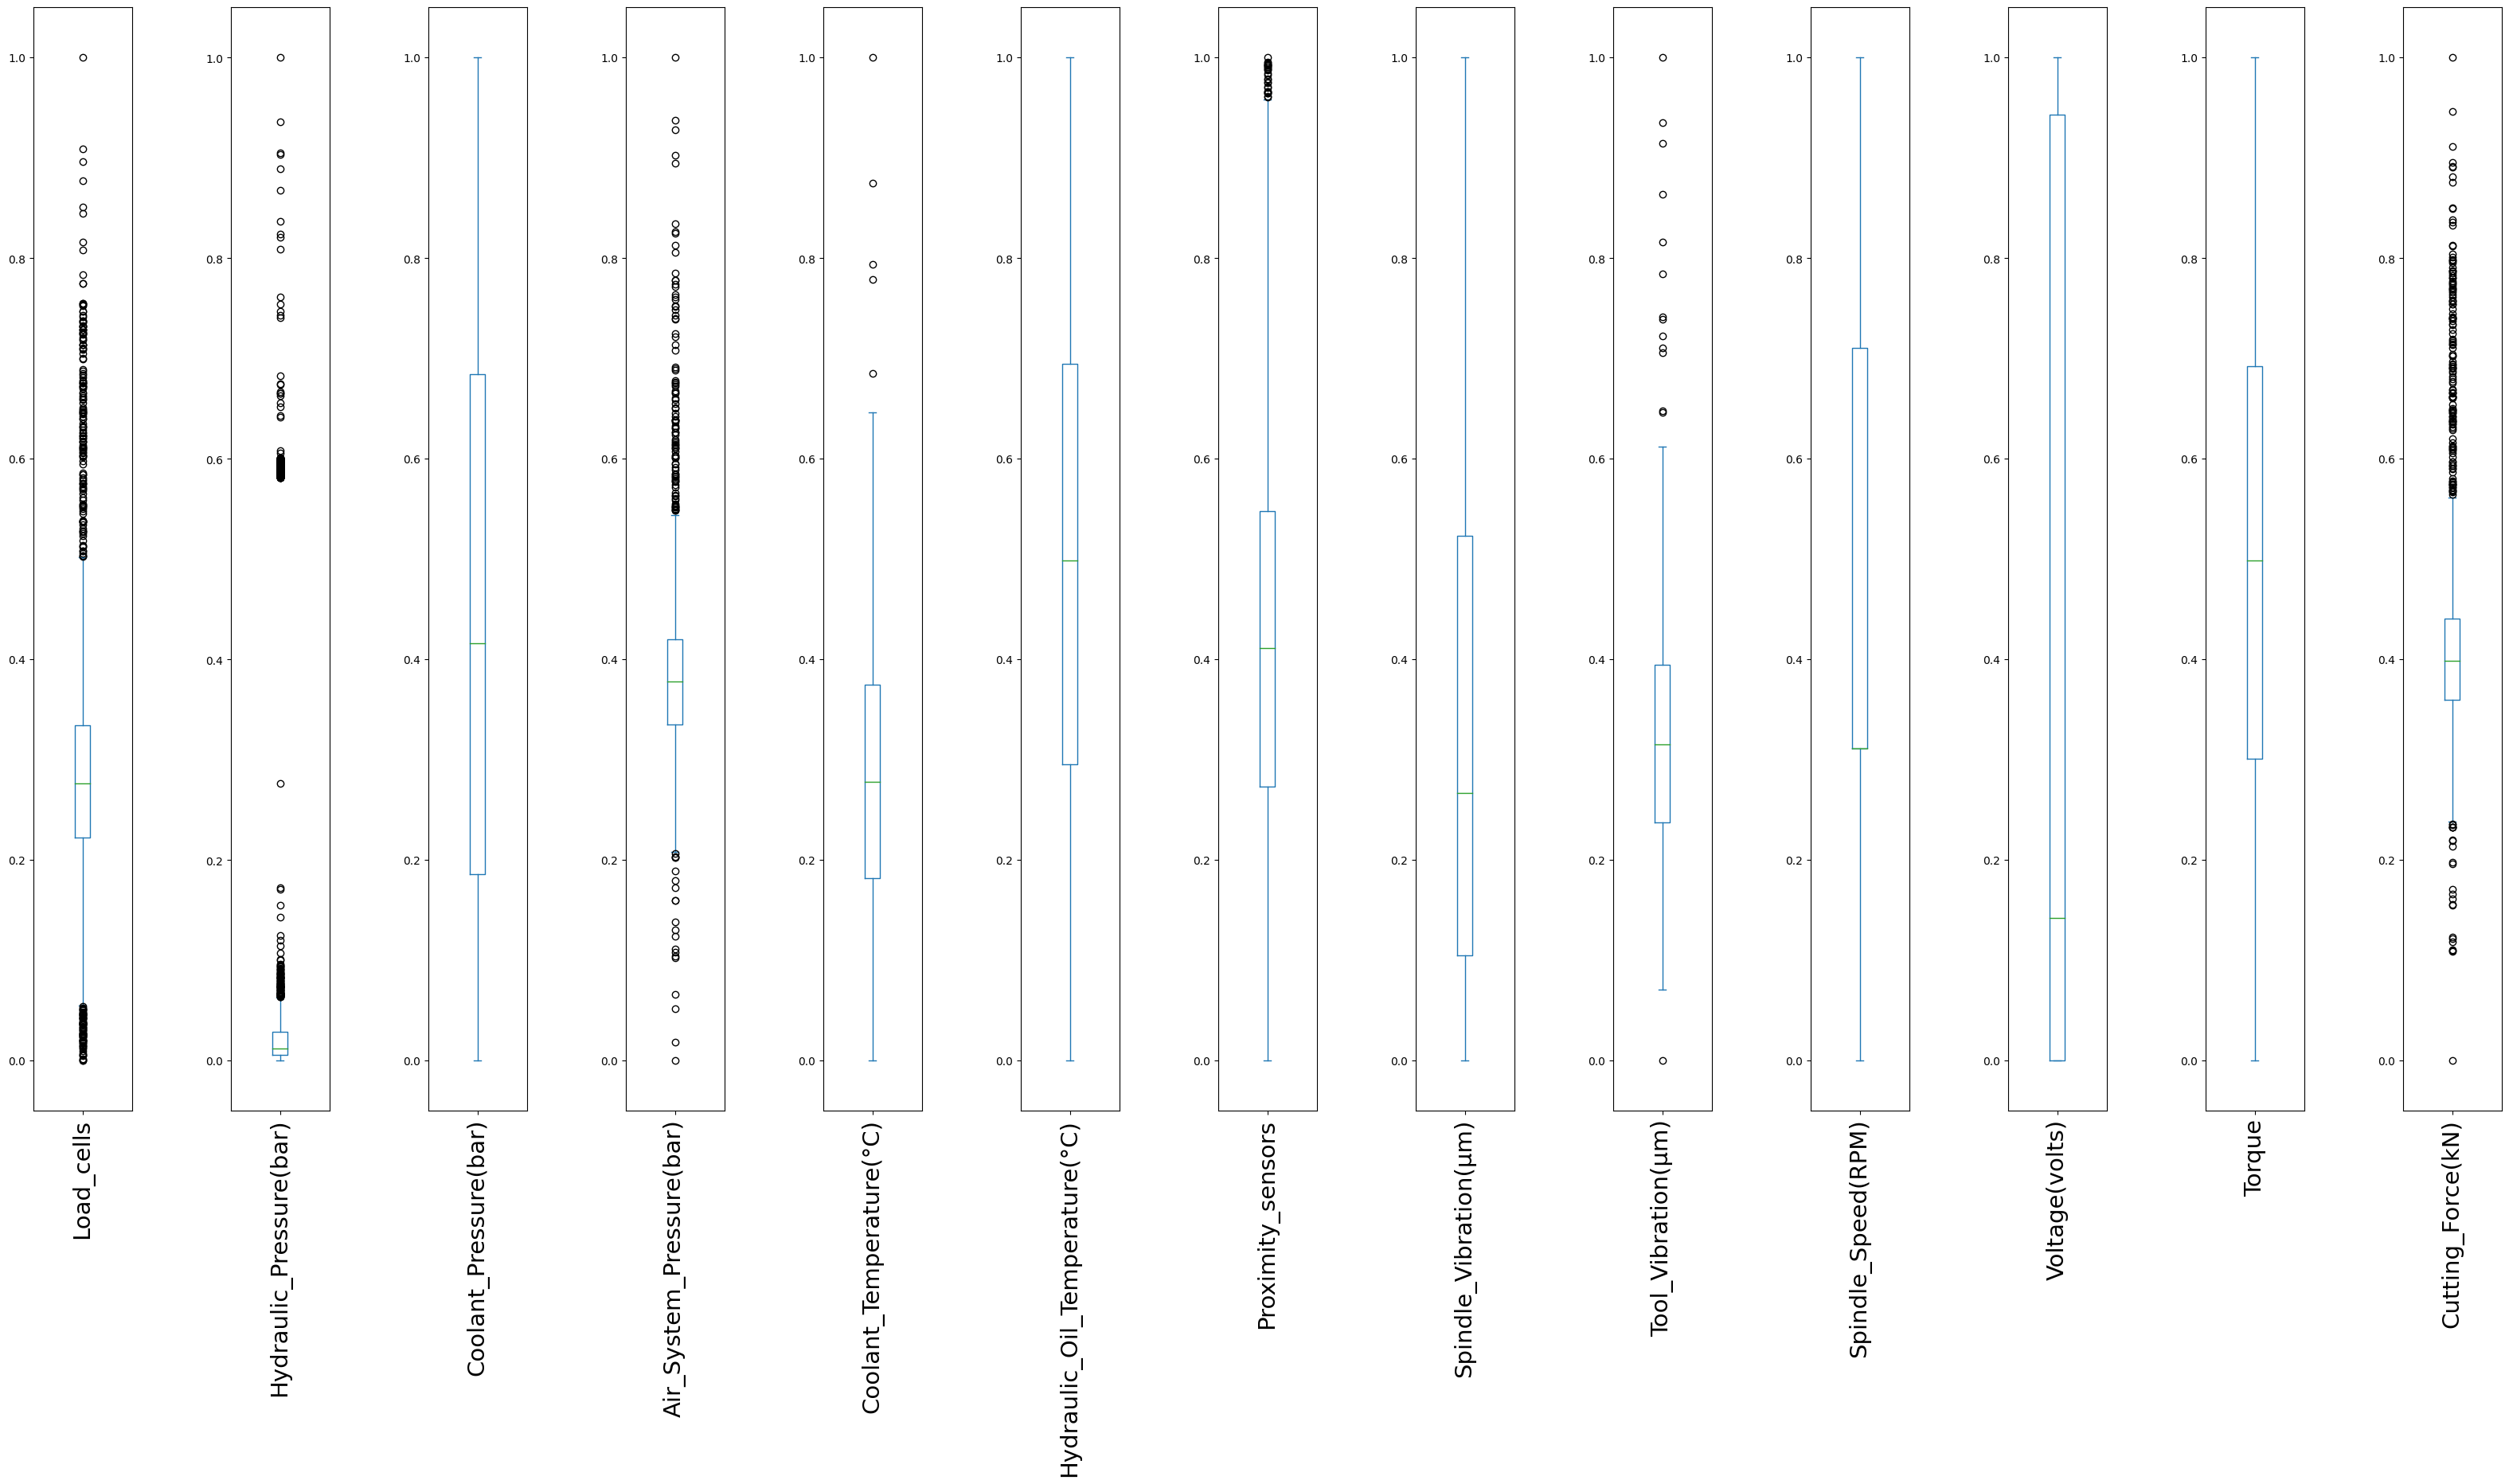

In [20]:
import os
os.getcwd()

import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already set up the 'processed' object as a pipeline that includes the SimpleImputer

# Transform the data using the 'processed' pipeline
cleandata = pd.DataFrame(processed.transform(df_x), columns=df_x.columns)

# Display information about the DataFrame
cleandata.info()

# columns list
columns_list = list(cleandata.columns)
columns_list

# Boxplot before cleaning
ax = cleandata.plot(kind='box', subplots=True, sharey=False, figsize=(40, 18))
# Set x-axis labels rotation and fontsize for each subplot
for subplot in ax:
    subplot.set_xticklabels(subplot.get_xticklabels(), rotation=90, fontsize=21)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=1.0)
# Show the plot
plt.show()



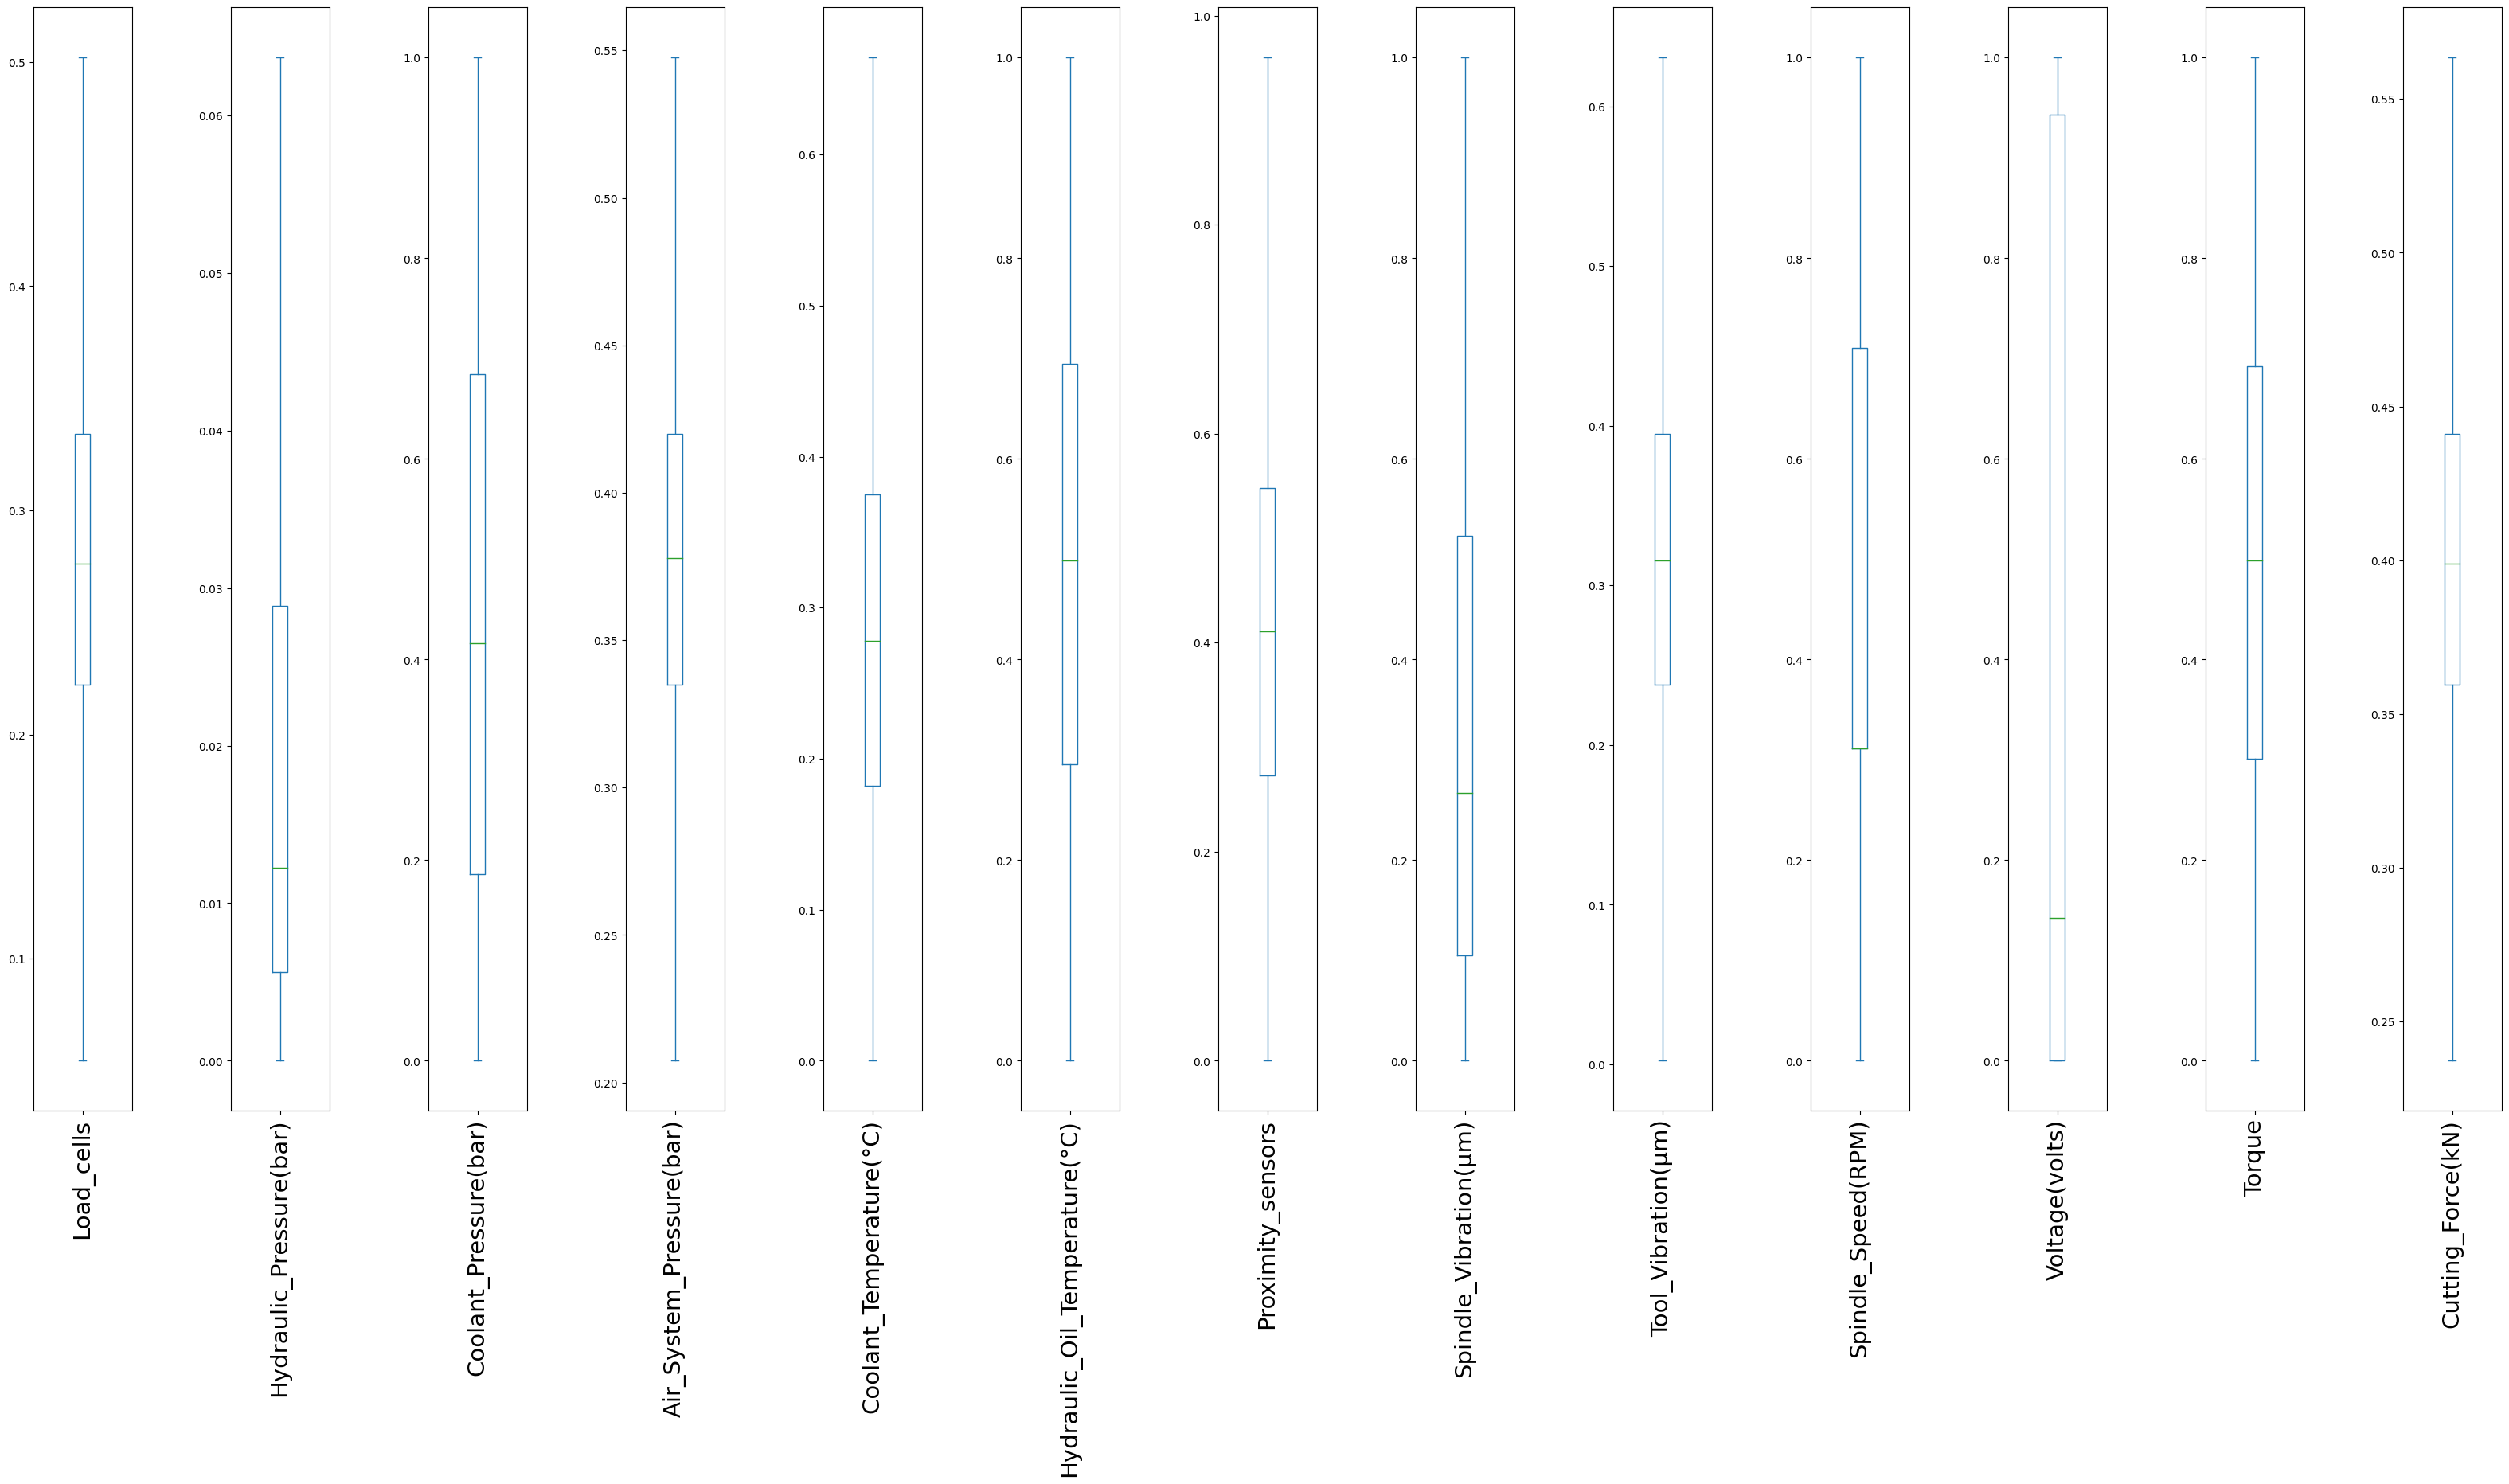

In [21]:
winsor = Winsorizer(capping_method = 'iqr', # choose  IQR rule boundaries or gaussian for mean and std
                          tail = 'both', # cap left, right or both tails
                          fold = 1.5,
                          variables = columns_list)

# Fit the winsorizer to numerical columns
outlier = winsor.fit(cleandata[columns_list])
# Save the fitted winsorizer model
joblib.dump(outlier, 'winsor')
cleandata[columns_list] = outlier.transform(cleandata[columns_list])

########## Boxplot after cleaning
ax = cleandata.plot(kind='box', subplots=True, sharey=False, figsize=(40, 18))
# Set x-axis labels rotation and fontsize for each subplot
for subplot in ax:
    subplot.set_xticklabels(subplot.get_xticklabels(), rotation=90, fontsize=21)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=1.0)
# Show the plot
plt.show()

In [22]:
df_y['Downtime'].value_counts()

NON_FAILURE    2400
FAILURE         300
Name: Downtime, dtype: int64

In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(cleandata, df_y)
X_resampled.shape
y_resampled.shape
y_resampled['Downtime'].value_counts()


NON_FAILURE    2400
FAILURE        2400
Name: Downtime, dtype: int64

In [24]:
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 0, stratify = y_resampled)
# X_train, X_test, Y_train, Y_test = train_test_split(cleandata, df_y, test_size = 0.2, random_state = 0, stratify = df_y)

X_train.shape
X_test.shape
Y_train.value_counts()
Y_test.value_counts()


Downtime   
FAILURE        480
NON_FAILURE    480
dtype: int64

In [25]:
# Model building
# Best Model
############ Naive bayes from Automl Pycarret
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

Gausian = GaussianNB(priors=None, var_smoothing=1e-09)

model_nb = Gausian.fit(X_train.values, Y_train.values.ravel())


In [26]:
pred = model_nb.predict(X_train.values)

In [27]:
accuracy = accuracy_score(Y_train, pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9841145833333333


In [28]:
report = classification_report(Y_train, pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     FAILURE       0.97      1.00      0.98      1920
 NON_FAILURE       1.00      0.97      0.98      1920

    accuracy                           0.98      3840
   macro avg       0.98      0.98      0.98      3840
weighted avg       0.98      0.98      0.98      3840



In [29]:
pred_test = model_nb.predict(X_test.values)


In [30]:
# Evaluate the model's performance
accuracy = accuracy_score(Y_test, pred_test)
print("Test Accuracy:", accuracy)



Test Accuracy: 0.9864583333333333


In [31]:
report = classification_report(Y_test, pred_test)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     FAILURE       0.97      1.00      0.99       480
 NON_FAILURE       1.00      0.97      0.99       480

    accuracy                           0.99       960
   macro avg       0.99      0.99      0.99       960
weighted avg       0.99      0.99      0.99       960



In [32]:
pickle.dump(model_nb, open('Naive_bayes.pkl','wb'))

In [33]:
!pip install evidently==0.3.0

In [34]:
import evidently
evidently.__version__

'0.3.0'

In [35]:
from evidently import ColumnMapping
from evidently.test_suite import TestSuite

In [36]:
from evidently.tests import *

In [37]:
from evidently.metrics import *
from evidently.report import Report
from evidently.metric_preset import TargetDriftPreset

In [39]:
X_train['target'] = Y_train
X_train['prediction'] = pred

X_test['target']=Y_test
X_test['prediction']=pred_test

target='target'
column_mapping=ColumnMapping()
column_mapping.target=target
column_mapping.prediction='prediction'
column_mapping.numerical_features=numeric_features
column_mapping.categorical_features=categorical_features

##Data integrity Test
data_integrity_dataset_tests=TestSuite(tests=[TestNumberOfColumns(),
                                             TestNumberOfRows(),
                                             TestNumberOfMissingValues(),
                                             TestShareOfMissingValues(),
                                             TestNumberOfColumnsWithMissingValues(),
                                             TestNumberOfRowsWithMissingValues(),
                                             TestShareOfColumnsWithMissingValues(),
                                             TestShareOfRowsWithMissingValues(),
                                             TestNumberOfDifferentMissingValues(),
                                             TestNumberOfConstantColumns(),
                                             TestNumberOfEmptyRows(),
                                             TestNumberOfEmptyColumns(),
                                             TestNumberOfDuplicatedRows(),
                                             TestNumberOfDuplicatedColumns(),
                                             TestColumnsType(),])

data_integrity_dataset_tests.run(reference_data=X_train,current_data=X_test)
data_integrity_dataset_tests

#generate html report
data_integrity_dataset_tests.save_html('data_integrity_dataset_tests_report.html')

import os
os.getcwd()

'/content'